# Simulation of Extended Scenes with Poke and HCIPy

We are interested, on occasion, in detection of sources that aren't just points (bye bye exoplanets!). One such feature of interest in high-contrast imaging (HCI) are debris disks. There are a variety of reasons for this that I am not terribly qualified to explain, but they can inform planetary system formation in a very cool way. We can detect them in scattered light, which imparts a relatively significant linear polarization signature on the light.

To simulate a debris disks, we first consider our propagation operator $\mathbf{\mathcal{P}}$ which represents our forward model though our coronagraph, which interacts with a few complex masks.

$$\mathcal{P} = \mathcal{F}[\mathcal{F}[\mathcal{F}[\mathcal{F}[U_{o}] \times \mathbf{A}_{ep}] \times \mathbf{A}_{FPM}]\times \mathbf{A}_{LS}]$$

Our propagation operator is the Fourier transform, represented by $\mathcal{F}$. These operations are linear, so we can make use of a couple of theorems to make our simulation easier. The first is the convolution identity of the fourier transform. We know that a convolution is represented by a multiplication in the fourier domain.

$$A * B = \mathcal{F}^{-1} [\mathcal{F}[A] \mathcal{F}[B]]$$

Since the object (a disk) is conjugate to the image plane, we know that the relation between them is equal to the convolution of the object with the forward model's $\mathcal{P}$ point-response function.

$$\sum_{\theta_{x},\theta_{y}} PRF_{\theta_{x},\theta_{y}}$$

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import plots

In [206]:
pth = 'HR4796A/'
I = fits.getdata(pth+'I_HR4796A.fits')
Q = fits.getdata(pth+'Q_HR4796A.fits')
U = fits.getdata(pth+'U_HR4796A.fits')
V = fits.getdata(pth+'V_HR4796A.fits')
stokes_orig = [I,Q,U,V]

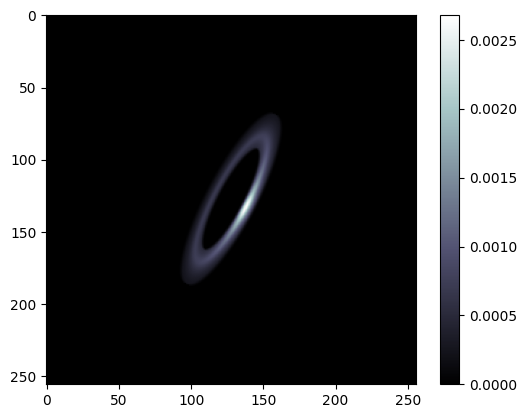

In [220]:
plt.imshow((I)**(1/3),cmap='bone')
plt.colorbar()

In [126]:
# assemble the forward model
from hcipy import *

aperture = make_magellan_aperture(True)

def forward_model(tiltsx,tiltsy,aperture,pupil_pix,focal_q,n_airy,order=4):
    """generate grid of PSFs, nyquist sampling the focal plane

    Parameters
    ----------
    tilts : numpy.ndarray
        array of PSF locations to simulate, units of L/D
    """

     # assemble the grids
    pupil_grid = make_pupil_grid(pupil_pix)
    focal_grid = make_focal_grid(focal_q,n_airy)

    print('focal grid shape = ',focal_grid.shape)

    focal_pix = focal_grid.shape[0]

    # set up a propagator
    prop = FraunhoferPropagator(pupil_grid,focal_grid)

    # set up the coronagraph
    eval_aperture = aperture(pupil_grid)
    coro = PerfectCoronagraph(eval_aperture,order)

    psf_grid = np.zeros([*tiltsx.shape,focal_pix,focal_pix])
    
    for i in range(tiltsx.shape[0]):
        for j in range(tiltsx.shape[1]):

            # create tilt wavefront
            tilt = np.exp(1j * 2 * np.pi * (pupil_grid.x * tiltsx[i,j] + pupil_grid.y * tiltsy[i,j]))

            # compute the PSF
            psf = prop(coro.forward(Wavefront(eval_aperture*tilt)))
            psf_grid[i,j] = psf.intensity.shaped

    return psf_grid


In [127]:
tilts = np.linspace(-12,12,256)
tx,ty = np.meshgrid(tilts,tilts)
psf_grid = forward_model(tx,ty,aperture,256,4,8)

focal grid shape =  [64 64]


In [128]:
psf_grid.shape

(256, 256, 64, 64)

In [159]:
psf_matrix = psf_grid.reshape([int(256**2),int(64**2)]).T

In [221]:
I_conv = psf_matrix @ I.ravel()
Q_conv = psf_matrix @ Q.ravel()
U_conv = psf_matrix @ U.ravel()
V_conv = psf_matrix @ V.ravel()

In [222]:
stokes = [I_conv.reshape([64,64]),
          Q_conv.reshape([64,64]),
          U_conv.reshape([64,64]),
          V_conv.reshape([64,64])]

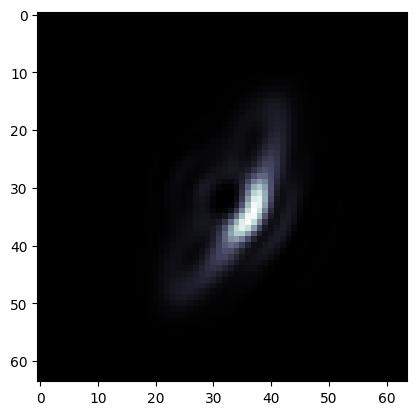

: 

In [226]:
plt.imshow(stokes[0],cmap='bone')

In [138]:
psf_matrix.nbytes * 1e-9

2.147483648

In [178]:
# Lets use double-difference PDI
pbs_angles = [0,np.pi/4,np.pi/2,3*np.pi/4]
single_differences = []
single_sums = []

# construct wavefront with disk


In [190]:
from importlib import reload
import instruments
reload(instruments)
from instruments import double_difference_stokes as pdi
Q,U = pdi(stokes)

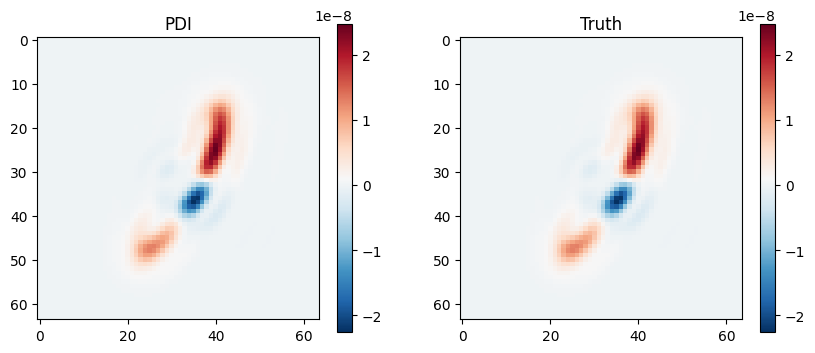

In [205]:
plt.figure(figsize=[10,4])
plt.subplot(121)
plt.title('PDI')
plt.imshow(U,cmap='RdBu_r')
plt.colorbar()
plt.subplot(122)
plt.title('Truth')
plt.imshow(-stokes[2],cmap='RdBu_r')
plt.colorbar()
plt.show()